[View in Colaboratory](https://colab.research.google.com/github/kigil/DL/blob/master/18M15184_report2.ipynb)

# Machine Learning: Intermediate report

+ 山野上勇人 (18M15184)

Prepare an environment for running Python codes on Jupyter notebook. The most easiest way is to use [Google Colaboratory](https://colab.research.google.com/).

Write codes for the following three (and one optional) problems, and submit the notebook (`.ipynb`) as well as its HTML conversion (`.html`). *We do not accept a report in other formats (e.g., Word, PDF)*. Write a code at the specified cell in the notebook. One can add more cells if necessary.

These are the links to the sample codes used in the lecture:

+ [Binary classification](https://github.com/chokkan/deeplearningclass/blob/master/mlp_binary.ipynb)
+ [MNIST](https://github.com/chokkan/deeplearningclass/blob/master/mnist.ipynb)

## 1. Multi-class classification on MNIST

Train a model on the training set of MNIST, and report the accuracy of the model on the test set. One can use the same code shown in the lecture. Write a code here and show the output.

In [0]:
import gzip
import os
import sys
import struct
import numpy as np

def read_image(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [2]:
!pip install livelossplot

  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


##Perceptron algorithm for single-layer neural network

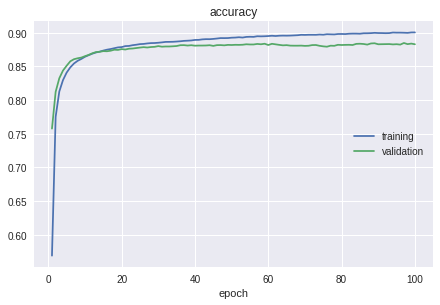

Accuracy: 0.8830 (test), 0.9006 (train)


In [3]:
import numpy as np
from livelossplot import PlotLosses

def image_to_vector(X):
    X = np.reshape(X, (len(X), -1))     # Flatten: (N x 28 x 28) -> (N x 784)
    return np.c_[X, np.ones(len(X))]    # Append 1: (N x 784) -> (N x 785)

data = np.load('mnist.npz')
Xtrain = image_to_vector(data['train_x'])
Ytrain = data['train_y']
Xtest = image_to_vector(data['test_x'])
Ytest = data['test_y']

W = np.random.randn(10, 28*28+1)

eta = 0.001
liveloss = PlotLosses()
for t in range(100):
    # Structured perceptron for updating weights.
    num_correct_train = 0
    for x, y in zip(Xtrain, Ytrain):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred != y:
            W[y] += x * eta
            W[y_pred] -= x * eta
        else:
            num_correct_train += 1

    # Evaluate and store the accuracy on the test set.
    num_correct_test = 0
    for x, y in zip(Xtest, Ytest):
        y_pred = np.argmax(np.dot(W, x))
        if y_pred == y:
            num_correct_test += 1
    
    # Visualize accuracy values on the training and test sets.
    liveloss.update({
        'accuracy': float(num_correct_train) / len(Ytrain),
        'val_accuracy': float(num_correct_test) / len(Ytest)
    })
    liveloss.draw()
    
print('Accuracy: {:.4f} (test), {:.4f} (train)'.format(
    float(num_correct_test) / len(Ytest), 
    float(num_correct_train) / len(Ytrain)
    ))　

## 2. Confusion matrix

Show a confusion matrix of the predictions of the model on the test set. This is an example of a confusion matrix.

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusion-matrix.png?raw=1)

Write a code here and show the confusion matrix.

In [23]:
from sklearn.metrics import confusion_matrix
WX = Xtest.dot(W.T)
Ypred = np.argmax(WX,axis=1)
print(confusion_matrix(Ytest,Ypred))

[[ 939    0    2    3    3   15   12    3    3    0]
 [   0 1102    8    3    1    3    3    2   13    0]
 [  11   21  846   53   13   17   16    6   46    3]
 [   5    2   24  868    2   51    2   20   19   17]
 [   1    3   11    9  875    4    8    9   15   47]
 [  13    3    7   41   10  761   10    5   31   11]
 [  11    5   22    5   10   34  858    2    7    4]
 [   1    9   14   11   11    6    0  909    9   58]
 [  12   21    8   43   11   58   16    8  774   23]
 [   6    8    0   12   32   12    3   28   10  898]]


## 3. Top-3 confusing examples

Show the top three images where the model misrecognized their digits with strong confidences. More specifically, let $y_n$ and $\hat{y}_n$ the true and predicted, respectively, digits of the image $x_n$. We want to find three images with high $P(\hat{y}_n | x_n)$ when $y_n \neq \hat{y}_n$.

Please show $y_n$, $P(y_n | x_n)$, $\hat{y}_n$, and $P(\hat{y}_n | x_n)$. This is an example of an output for an image (you need this kind of outputs for top-three images).

![example](https://github.com/chokkan/deeplearningclass/blob/master/assignment/example-confusing-sample.png?raw=1)

Write a code here and show the output.

##確率の取得

In [0]:
def softmax(wx):
  exp = np.exp(wx)
  return exp/exp.sum(axis=0)

Yprob = softmax(WX.T)
Ypred_prob = Yprob.max(axis=0)

##Top3のindexを取得

In [0]:
index = []
miss = []
for i,(t,p) in enumerate(zip(Ytest,Ypred)):
  if t != p:
    miss.append(True)
    index.append(i)
  else:
    miss.append(False)
    
Ymiss = Ypred_prob[miss]
top3_prob = np.sort(Ymiss)[::-1][:3]
top3_index = []
for v in top3_prob:
  top3_index.append(index[np.where(Ymiss == v)[0][0]])
  

##解答の出力

True digit:8(0.0003489190322882736); Prediction:4 (0.9971516089098112)


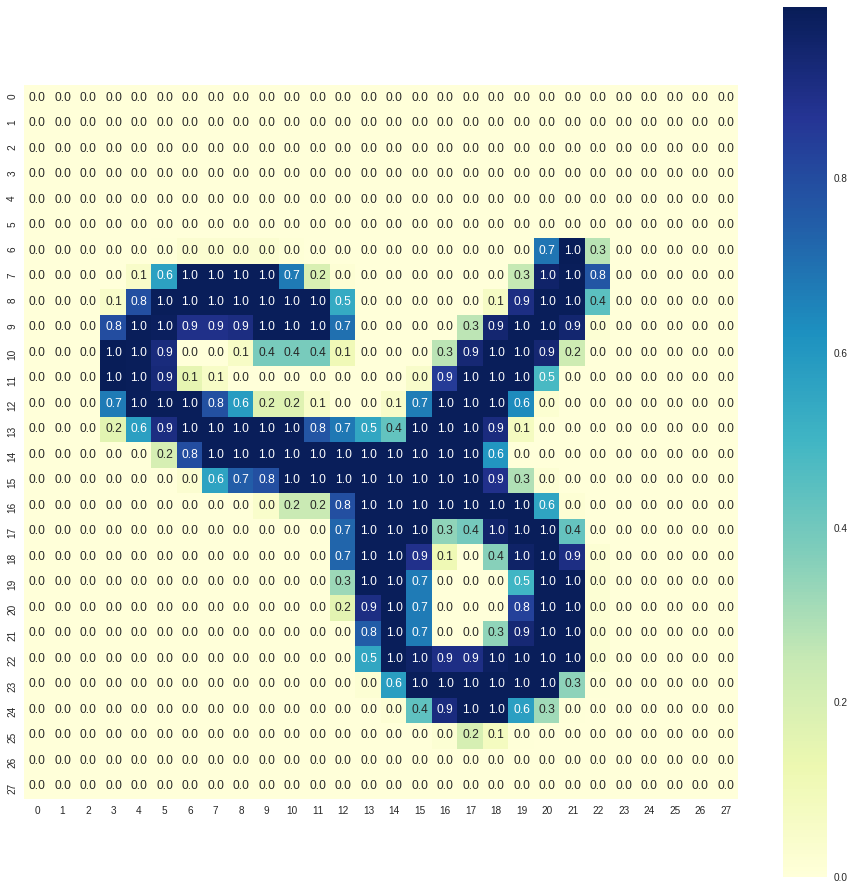

True digit:8(0.0030285743964479288); Prediction:1 (0.9944191417956388)


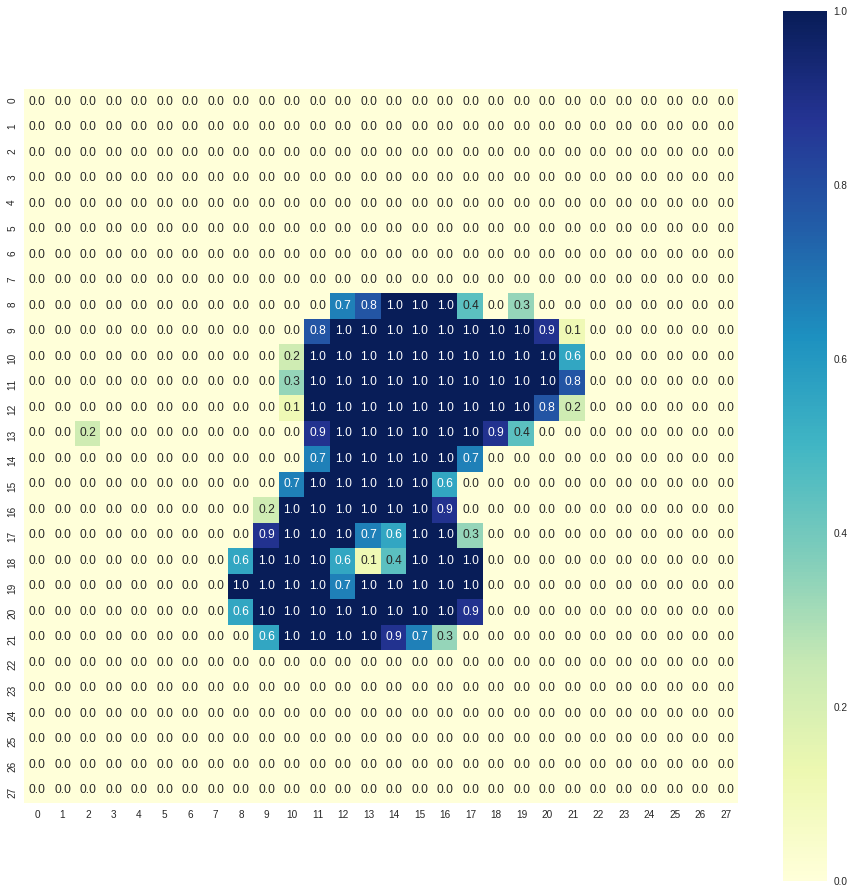

True digit:2(0.00401249276781645); Prediction:0 (0.9936585776615183)


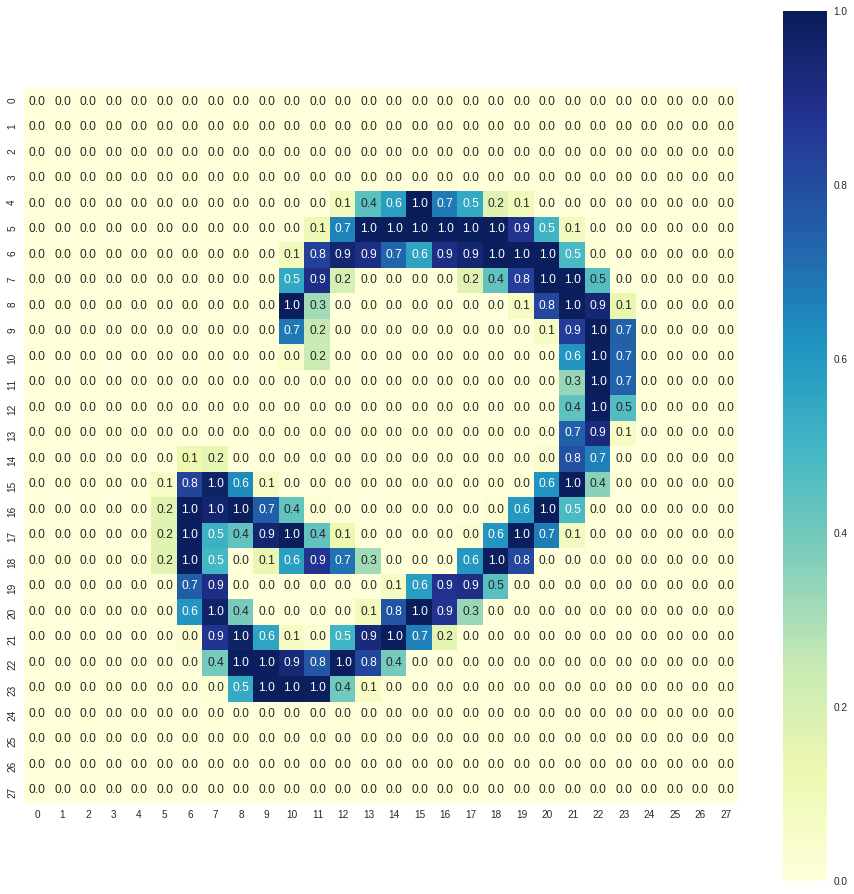

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

data = np.load('mnist.npz')

for i,p in zip(top3_index,top3_prob):
  image = data['test_x'][i]
  label = data['test_y'][i]

  print(f"True digit:{label}({Yprob.T[i][label]}); Prediction:{np.argmax(Y_prob.T[i])} ({p})")
  f, ax = plt.subplots(figsize=(16, 16))
  sns.heatmap(image, annot=True, fmt='.1f', square=True, cmap="YlGnBu")
  plt.show()

## 4. Sample codes in other DL frameworks

(Advanced; optional) Implement one or more sample code(s) with a different deep learning framework (e.g., Chainer, TensorFlow, DyNet) corresponding to the slides 60-66 in binary classification. *When subitting an answer to this problem, please agree that some of the submitted codes will be distributed on the Web site to improve this lecture.*